### Análisis Exploratorio del Dataset

### Autor: Chavez Aquino, Cecilio

### Librerías

In [1]:
# Librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
from IPython.display import Audio
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.io import loadmat
from scipy.stats import kurtosis, skew
from scipy.fft import fft
import pywt
from scipy.signal import spectrogram
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.signal import welch
from sklearn.model_selection import cross_val_score


### Carga y lectura de datos acústicos

In [3]:
# Ruta al archivo .mat
file_dataset = "D:/Rodamientos/dataset.mat"

# Cargar el archivo .mat
dataset = loadmat(file_dataset)

# Identificar las clases de sonidos
print("Claves en el archivo .mat:", dataset.keys())


Claves en el archivo .mat: dict_keys(['__header__', '__version__', '__globals__', 'normal', 'inner', 'roller', 'outer'])


In [4]:
Data_normal = dataset["normal"]
Data_inner = dataset["inner"]
Data_roller = dataset["roller"]
Data_outer = dataset["outer"]

display(Data_normal.shape, Data_inner.shape, Data_roller.shape, Data_outer.shape)

(1, 120000)

(1, 120000)

(1, 120000)

(1, 120000)

In [5]:
# Clases y número de datos
classes = ['normal', 'inner', 'roller', 'outer']
data_counts = [Data_normal.shape[1], Data_inner.shape[1], Data_roller.shape[1], Data_outer.shape[1]]

# Crear un DataFrame para mostrar los datos
df = pd.DataFrame({'Clase': classes, 'Cantidad de Datos': data_counts})
# Visualización como tabla
df.style.set_caption("Distribución de Datos por Clase")


,Clase,Cantidad de Datos
0,normal,120000
1,inner,120000
2,roller,120000
3,outer,120000


### Métricas estadísticas de las señales en el dominio del tiempo

In [10]:
def calcular_metricas(datos):
    media = np.mean(datos)
    mediana = np.median(datos)
    std = np.std(datos)
    rms = np.sqrt(np.mean(np.square(datos)))
    curt = kurtosis(datos)
    asimetria = skew(datos)
    factor_cresta = np.max(np.abs(datos)) / rms
    indice_impulsividad = np.max(np.abs(datos)) / np.mean(np.abs(datos))
    
    return [media, mediana, std, rms, curt, asimetria, factor_cresta, indice_impulsividad]

# Calcular métricas para cada clase
metricas = {clase: calcular_metricas(datos) for clase, datos in Data_classes.items()}

# Crear DataFrame para visualizar
columnas = ["Media", "Mediana", "STD", "RMS", "Curtosis", "Asimetría", "Fact. de Cresta", "Índice de Impul."]
df_metricas = pd.DataFrame.from_dict(metricas, orient='index', columns=columnas)

# Mostrar la tabla
display(df_metricas)

,Media,Mediana,STD,RMS,Curtosis,Asimetría,Fact. de Cresta,Índice de Impul.
Normal,0.012582,0.012726,0.072674,0.073755,-0.229891,-0.035449,4.220081,5.232298
Inner,0.013455,0.007147,0.291079,0.291390,2.395356,0.163764,5.968051,8.328508
Roller,0.012667,0.012832,0.138533,0.139111,-0.026291,-0.008959,4.363573,5.464748
Outer,0.023300,0.022132,0.668851,0.669257,4.653372,0.056565,5.424564,8.949963


### Matriz de correlación de las señales en el dominio del tiempo

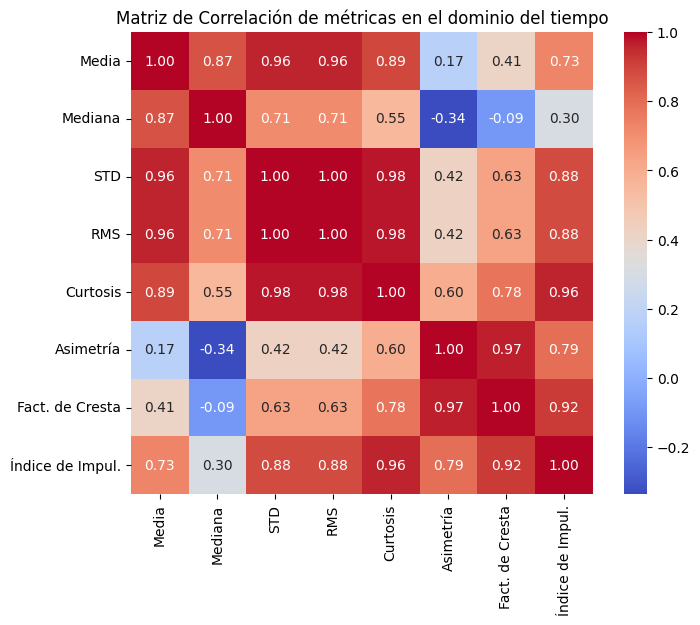

In [11]:
def generar_matriz_correlacion(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title("Matriz de Correlación de métricas en el dominio del tiempo")
    plt.show()

# Generar y visualizar la matriz de correlación
generar_matriz_correlacion(df_metricas)


### Selección de características de las señales en el dominio del tiempo


Características Seleccionadas:

Index(['Mediana', 'STD', 'Asimetría'], dtype='object')


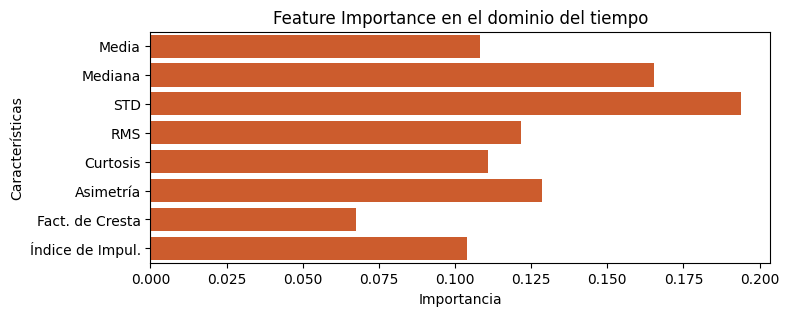

Index(['Mediana', 'STD', 'Asimetría'], dtype='object')

In [21]:
def seleccion_caracteristicas(df, etiquetas):
    modelo_rf = RandomForestClassifier(random_state=42)
    modelo_rf.fit(df, etiquetas)

    selector = SelectFromModel(modelo_rf, prefit=True)
    caracteristicas_seleccionadas = df.columns[selector.get_support()]

    print("\nCaracterísticas Seleccionadas:\n")
    print(caracteristicas_seleccionadas)

    # Importancia de características
    importancias = modelo_rf.feature_importances_
    plt.figure(figsize=(8, 3))
    sns.barplot(x=importancias, y=df.columns, color="#E65113")
    plt.title("Feature Importance en el dominio del tiempo")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()

    return caracteristicas_seleccionadas

# Simular etiquetas para cada clase
etiquetas = [0, 1, 2, 3]  # Clases codificadas como 0: Normal, 1: Falla Pista Interna, etc.

df_metricas.reset_index(drop=True, inplace=True)  # Resetear índices para compatibilidad
seleccion_caracteristicas(df_metricas, etiquetas)

### Métricas estadísticas de las señales en el dominio de la frecuencia

In [13]:
def calcular_metricas_frecuencia(datos, fs=10000):
    n = len(datos)
    freqs = np.fft.fftfreq(n, d=1/fs)
    fft_values = np.abs(fft(datos))

    # Considerar solo la mitad del espectro
    freqs = freqs[:n // 2]
    fft_values = fft_values[:n // 2]

    frecuencia_media = np.sum(freqs * fft_values) / np.sum(fft_values)
    frecuencia_dominante = freqs[np.argmax(fft_values)]
    ancho_banda = np.sqrt(np.sum((freqs - frecuencia_media)**2 * fft_values) / np.sum(fft_values))
    energia_espectral = np.sum(fft_values**2)
    entropia_espectral = -np.sum((fft_values / np.sum(fft_values)) * np.log(fft_values / np.sum(fft_values) + 1e-12))

    return [frecuencia_media, frecuencia_dominante, ancho_banda, energia_espectral, entropia_espectral]

# Calcular métricas de frecuencia para cada clase
metricas_frecuencia = {clase: calcular_metricas_frecuencia(datos) for clase, datos in Data_classes.items()}

# Crear DataFrame para visualizar
columnas_frecuencia = ["Frec. Media", "Frec. Dominante", "Ancho de Banda", "Ener. Espectral", "Entrop. Espectral"]
df_metricas_frecuencia = pd.DataFrame.from_dict(metricas_frecuencia, orient='index', columns=columnas_frecuencia)

# Mostrar la tabla de métricas de frecuencia
print("\nTabla de Métricas en el Dominio de Frecuencia:\n")
display(df_metricas_frecuencia)


Tabla de Métricas en el Dominio de Frecuencia:



,Frec. Media,Frec. Dominante,Ancho de Banda,Ener. Espectral,Entrop. Espectral
Normal,1558.172089,1726.833333,1105.863786,4.030678e+07,10.088334
Inner,2419.953453,2989.083333,919.955791,6.126421e+08,9.890063
Roller,2382.842210,0.000000,818.161685,1.404882e+08,9.758023
Outer,2726.631845,2780.750000,777.834662,3.228821e+09,9.333925


### Matriz de correlación de las señales en el dominio de la frecuencia

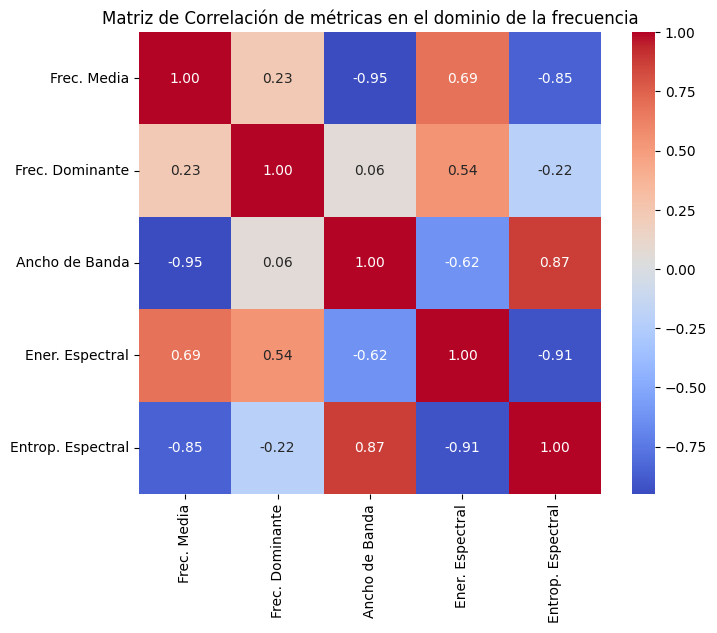

In [14]:
def generar_matriz_correlacion(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title("Matriz de Correlación de métricas en el dominio de la frecuencia")
    plt.show()

# Generar y visualizar la matriz de correlación
generar_matriz_correlacion(df_metricas_frecuencia)

### Selección de características de las señales en el dominio de la frecuencia


Características Seleccionadas:

Index(['Frec. Media', 'Ener. Espectral', 'Entrop. Espectral'], dtype='object')


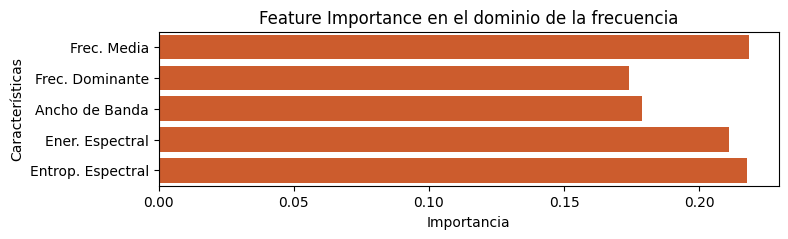

Index(['Frec. Media', 'Ener. Espectral', 'Entrop. Espectral'], dtype='object')

In [24]:
def seleccion_caracteristicas(df, etiquetas):
    modelo_rf = RandomForestClassifier(random_state=42)
    modelo_rf.fit(df, etiquetas)

    selector = SelectFromModel(modelo_rf, prefit=True)
    caracteristicas_seleccionadas = df.columns[selector.get_support()]

    print("\nCaracterísticas Seleccionadas:\n")
    print(caracteristicas_seleccionadas)

    # Importancia de características
    importancias = modelo_rf.feature_importances_
    plt.figure(figsize=(8, 2))
    sns.barplot(x=importancias, y=df.columns, color="#E65113")
    plt.title("Feature Importance en el dominio de la frecuencia")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()

    return caracteristicas_seleccionadas

# Simular etiquetas para cada clase
etiquetas = [0, 1, 2, 3]  # Clases codificadas como 0: Normal, 1: Falla Pista Interna, etc.

df_metricas.reset_index(drop=True, inplace=True)  # Resetear índices para compatibilidad
seleccion_caracteristicas(df_metricas_frecuencia, etiquetas)

### Métricas estadísticas de las señales en el dominio del tiempo - frecuencia

In [16]:
def calcular_metricas_tiempo_frecuencia(datos, fs=10000):
    # Espectrograma
    f, t, Sxx = spectrogram(datos, fs=fs)
    energia_bandas = [np.sum(Sxx[(f >= low) & (f < high), :]) for low, high in [(0, 500), (500, 1000), (1000, 2000)]]
    promedio_espectrograma = np.mean(Sxx)
    tiempo_pico_espectral = t[np.argmax(np.sum(Sxx, axis=0))]

    # Coeficientes Wavelet
    coeficientes_wavelet = pywt.wavedec(datos, 'db4', level=4)
    energia_wavelet = [np.sum(np.square(c)) for c in coeficientes_wavelet]

    return energia_bandas + energia_wavelet[:1] + [promedio_espectrograma, tiempo_pico_espectral]

# Calcular métricas tiempo-frecuencia para cada clase
metricas_tiempo_frecuencia = {clase: calcular_metricas_tiempo_frecuencia(datos) for clase, datos in Data_classes.items()}

# Crear DataFrame para visualizar
columnas_tiempo_frecuencia = ["Energ. 0-500 Hz", "Energ. 500-1000 Hz", "Energ. 1000-2000 Hz", "Coef. Wavelet", "Prom. Espectrograma", "Tiempo Pico Espectral"]
df_metricas_tiempo_frecuencia = pd.DataFrame.from_dict(metricas_tiempo_frecuencia, orient='index', columns=columnas_tiempo_frecuencia)

# Mostrar la tabla de métricas tiempo-frecuencia
print("\nTabla de Métricas en el Dominio Tiempo-Frecuencia:\n")
display(df_metricas_tiempo_frecuencia)


Tabla de Métricas en el Dominio Tiempo-Frecuencia:



,Energ. 0-500 Hz,Energ. 500-1000 Hz,Energ. 1000-2000 Hz,Coef. Wavelet,Prom. Espectrograma,Tiempo Pico Espectral
Normal,0.014951,0.003277,0.049319,120.113406,0.000001,0.1696
Inner,0.015938,0.087852,0.157273,69.538491,0.000017,3.7760
Roller,0.007856,0.009302,0.007839,45.008402,0.000004,4.2912
Outer,0.012792,0.027475,0.021737,104.817189,0.000089,8.0992


### Matriz de correlación de las señales en el dominio del tiempo - frecuencia

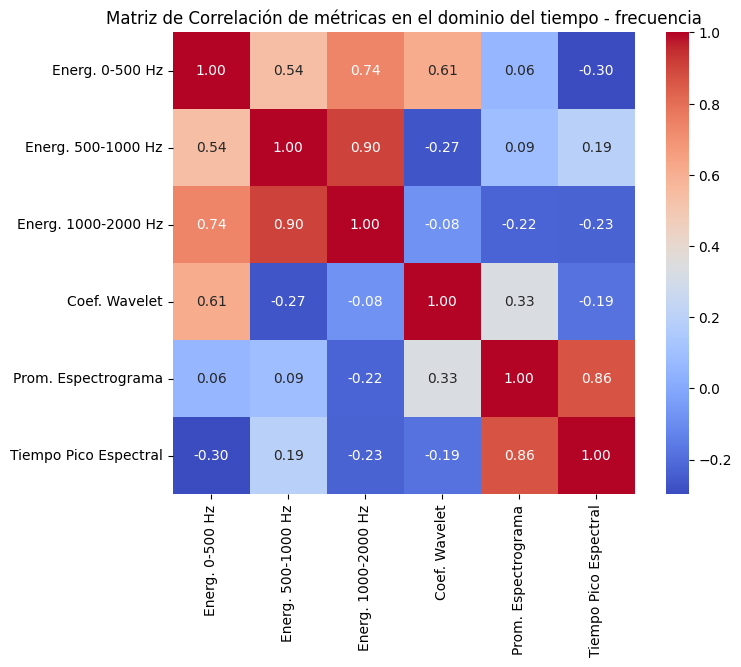

In [17]:
def generar_matriz_correlacion(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title("Matriz de Correlación de métricas en el dominio del tiempo - frecuencia")
    plt.show()

# Generar y visualizar la matriz de correlación
generar_matriz_correlacion(df_metricas_tiempo_frecuencia)

### Selección de características de las señales en el dominio del tiempo - frecuencia


Características Seleccionadas:

Index(['Energ. 0-500 Hz', 'Energ. 500-1000 Hz'], dtype='object')


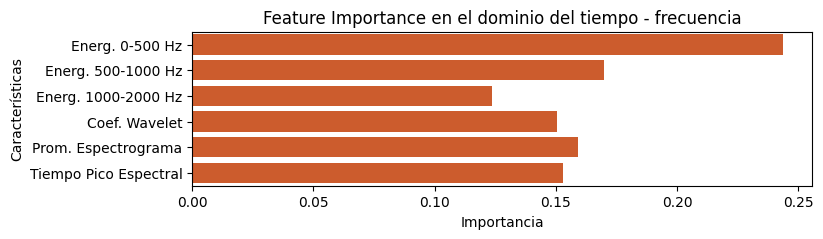

Index(['Energ. 0-500 Hz', 'Energ. 500-1000 Hz'], dtype='object')

In [25]:
def seleccion_caracteristicas(df, etiquetas):
    modelo_rf = RandomForestClassifier(random_state=42)
    modelo_rf.fit(df, etiquetas)

    selector = SelectFromModel(modelo_rf, prefit=True)
    caracteristicas_seleccionadas = df.columns[selector.get_support()]

    print("\nCaracterísticas Seleccionadas:\n")
    print(caracteristicas_seleccionadas)

    # Importancia de características
    importancias = modelo_rf.feature_importances_
    plt.figure(figsize=(8, 2))
    sns.barplot(x=importancias, y=df.columns, color="#E65113")
    plt.title("Feature Importance en el dominio del tiempo - frecuencia")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()

    return caracteristicas_seleccionadas

# Simular etiquetas para cada clase
etiquetas = [0, 1, 2, 3]  # Clases codificadas como 0: Normal, 1: Falla Pista Interna, etc.

df_metricas.reset_index(drop=True, inplace=True)  # Resetear índices para compatibilidad
seleccion_caracteristicas(df_metricas_tiempo_frecuencia, etiquetas)

### Espectrograma STFT - Transformada Wavelet de la clase "Normal"

C:\Users\cchavez\AppData\Local\anaconda3\envs\myenv\lib\site-packages\pywt\_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


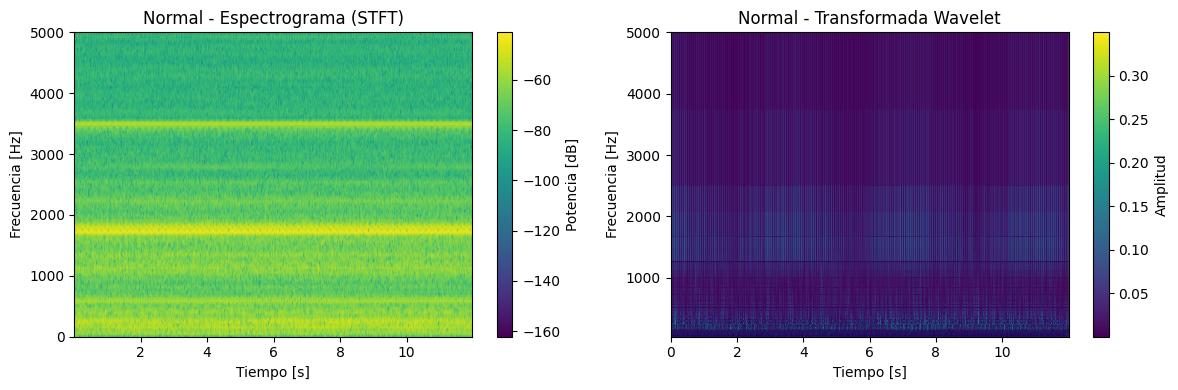

In [26]:
# Función para graficar el espectrograma (STFT)
def graficar_espectrograma(datos, fs=10000):
    f, t, Sxx = spectrogram(datos, fs=fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Potencia [dB]')
    plt.title('Normal - Espectrograma (STFT)')

# Función para graficar la Transformada Wavelet
def graficar_wavelet_transform(datos, wavelet='cmor', fs=10000):
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(datos, scales, wavelet, sampling_period=1/fs)
    plt.pcolormesh(np.arange(len(datos)) / fs, frequencies, np.abs(coefficients), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud')
    plt.title('Normal - Transformada Wavelet')

# Datos de la clase "Normal"
datos_normal = Data_classes["Normal"]

# Crear gráficos lado a lado
plt.figure(figsize=(12, 4))

# Gráfico 1: Espectrograma (STFT)
plt.subplot(1, 2, 1)
graficar_espectrograma(datos_normal, fs=10000)

# Gráfico 2: Transformada Wavelet
plt.subplot(1, 2, 2)
graficar_wavelet_transform(datos_normal, wavelet='cmor', fs=10000)

plt.tight_layout()
plt.show()


### Espectrograma STFT - Transformada Wavelet de la clase "Roller"

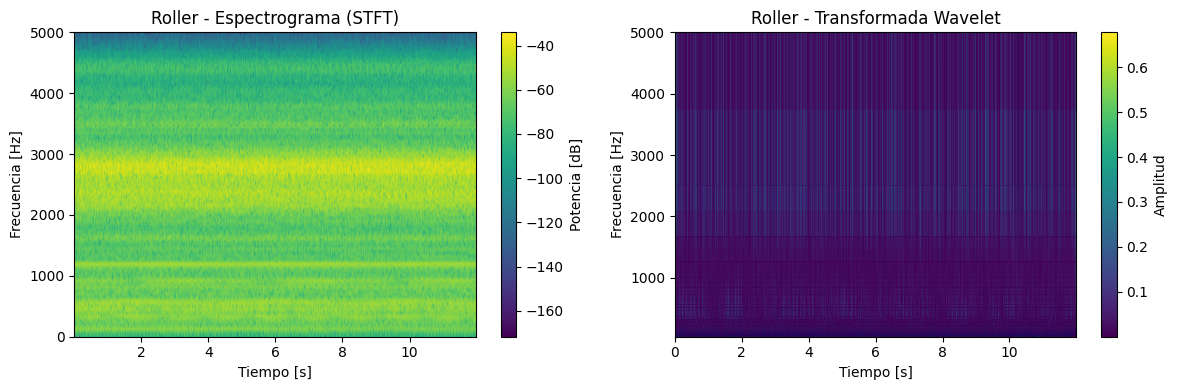

In [27]:
# Función para graficar el espectrograma (STFT)
def graficar_espectrograma(datos, fs=10000):
    f, t, Sxx = spectrogram(datos, fs=fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Potencia [dB]')
    plt.title('Roller - Espectrograma (STFT)')

# Función para graficar la Transformada Wavelet
def graficar_wavelet_transform(datos, wavelet='cmor', fs=10000):
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(datos, scales, wavelet, sampling_period=1/fs)
    plt.pcolormesh(np.arange(len(datos)) / fs, frequencies, np.abs(coefficients), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud')
    plt.title('Roller - Transformada Wavelet')

# Datos de la clase "Normal"
datos_normal = Data_classes["Roller"]

# Crear gráficos lado a lado
plt.figure(figsize=(12, 4))

# Gráfico 1: Espectrograma (STFT)
plt.subplot(1, 2, 1)
graficar_espectrograma(datos_normal, fs=10000)

# Gráfico 2: Transformada Wavelet
plt.subplot(1, 2, 2)
graficar_wavelet_transform(datos_normal, wavelet='cmor', fs=10000)

plt.tight_layout()
plt.show()



### Espectrograma STFT - Transformada Wavelet de la clase "Inner"

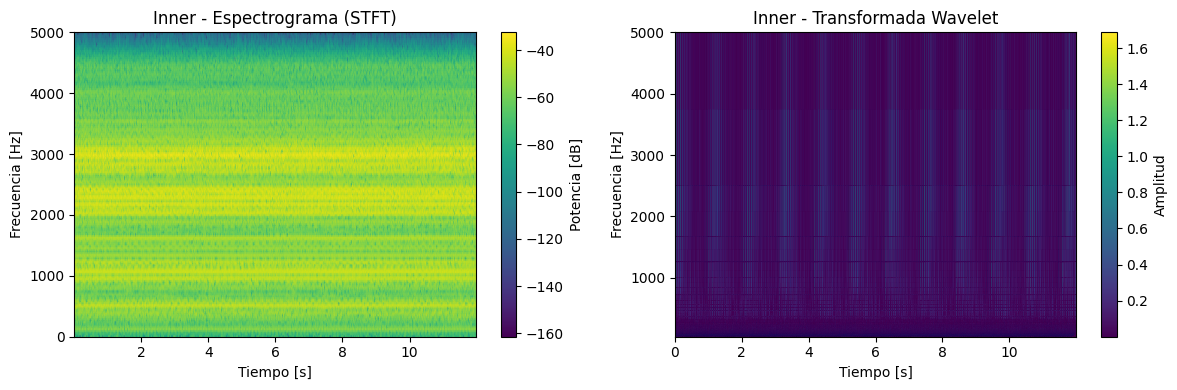

In [28]:
# Función para graficar el espectrograma (STFT)
def graficar_espectrograma(datos, fs=10000):
    f, t, Sxx = spectrogram(datos, fs=fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Potencia [dB]')
    plt.title('Inner - Espectrograma (STFT)')

# Función para graficar la Transformada Wavelet
def graficar_wavelet_transform(datos, wavelet='cmor', fs=10000):
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(datos, scales, wavelet, sampling_period=1/fs)
    plt.pcolormesh(np.arange(len(datos)) / fs, frequencies, np.abs(coefficients), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud')
    plt.title('Inner - Transformada Wavelet')

# Datos de la clase "Normal"
datos_normal = Data_classes["Inner"]

# Crear gráficos lado a lado
plt.figure(figsize=(12, 4))

# Gráfico 1: Espectrograma (STFT)
plt.subplot(1, 2, 1)
graficar_espectrograma(datos_normal, fs=10000)

# Gráfico 2: Transformada Wavelet
plt.subplot(1, 2, 2)
graficar_wavelet_transform(datos_normal, wavelet='cmor', fs=10000)

plt.tight_layout()
plt.show()

### Espectrograma STFT - Transformada Wavelet de la clase "Outer"

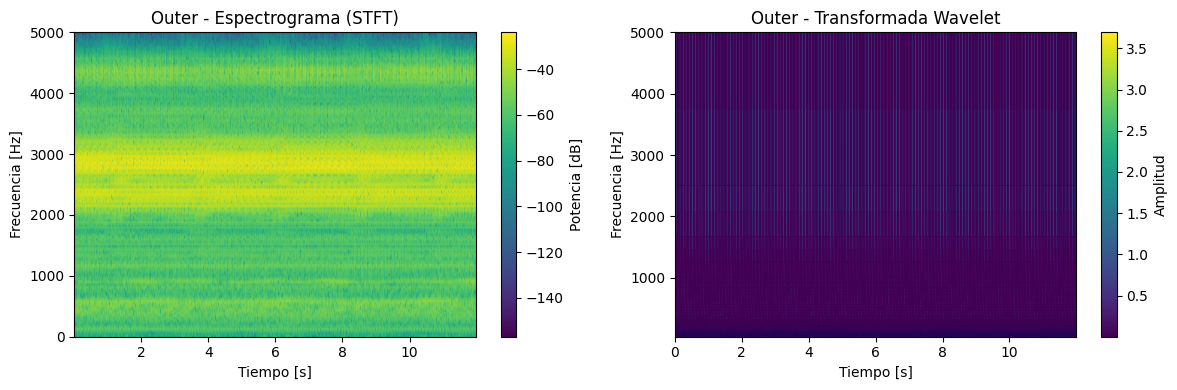

In [29]:
# Función para graficar el espectrograma (STFT)
def graficar_espectrograma(datos, fs=10000):
    f, t, Sxx = spectrogram(datos, fs=fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Potencia [dB]')
    plt.title('Outer - Espectrograma (STFT)')

# Función para graficar la Transformada Wavelet
def graficar_wavelet_transform(datos, wavelet='cmor', fs=10000):
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(datos, scales, wavelet, sampling_period=1/fs)
    plt.pcolormesh(np.arange(len(datos)) / fs, frequencies, np.abs(coefficients), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud')
    plt.title('Outer - Transformada Wavelet')

# Datos de la clase "Normal"
datos_normal = Data_classes["Outer"]

# Crear gráficos lado a lado
plt.figure(figsize=(12, 4))

# Gráfico 1: Espectrograma (STFT)
plt.subplot(1, 2, 1)
graficar_espectrograma(datos_normal, fs=10000)

# Gráfico 2: Transformada Wavelet
plt.subplot(1, 2, 2)
graficar_wavelet_transform(datos_normal, wavelet='cmor', fs=10000)

plt.tight_layout()
plt.show()

### Representación gráfica de las señales acústicas en el dominio del tiempo

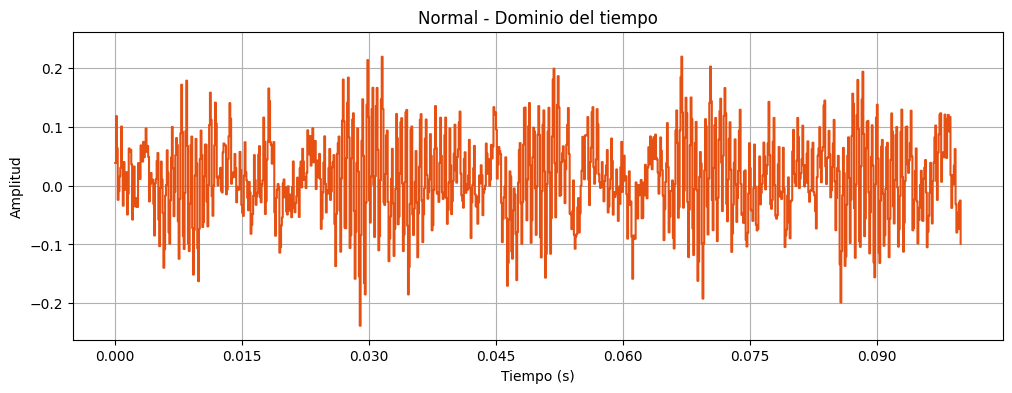

In [40]:
df_normal = Data_normal[0, 10000:11000]  # Seleccionar la primera señal si está en un array 2D

# Graficar la señal
plt.figure(figsize=(12, 4))
librosa.display.waveshow(df_normal[:1000], sr=frequence, color='#E65113')  # Cambiar color a naranja
plt.title("Normal - Dominio del tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()


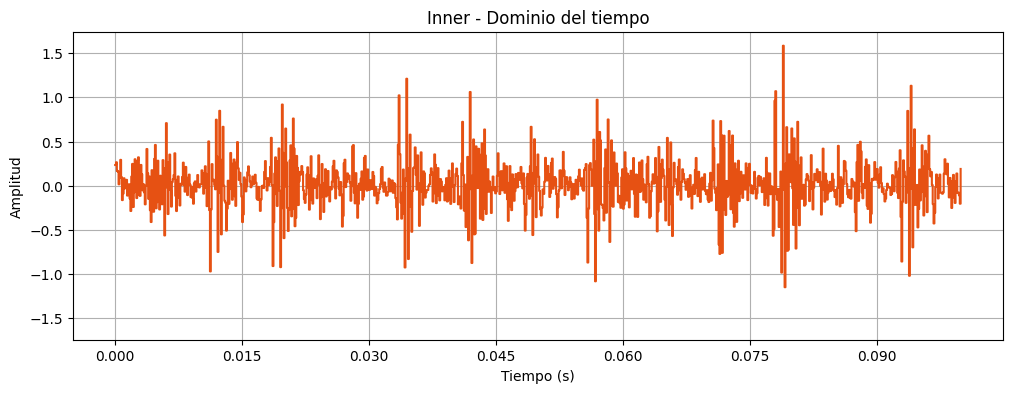

In [41]:
df_inner = Data_inner[0, 10000:11000]  # Seleccionar la primera señal si está en un array 2D

# Graficar la señal
plt.figure(figsize=(12, 4))
librosa.display.waveshow(df_inner[:1000], sr=frequence, color='#E65113')  # Cambiar color a naranja
plt.title("Inner - Dominio del tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()


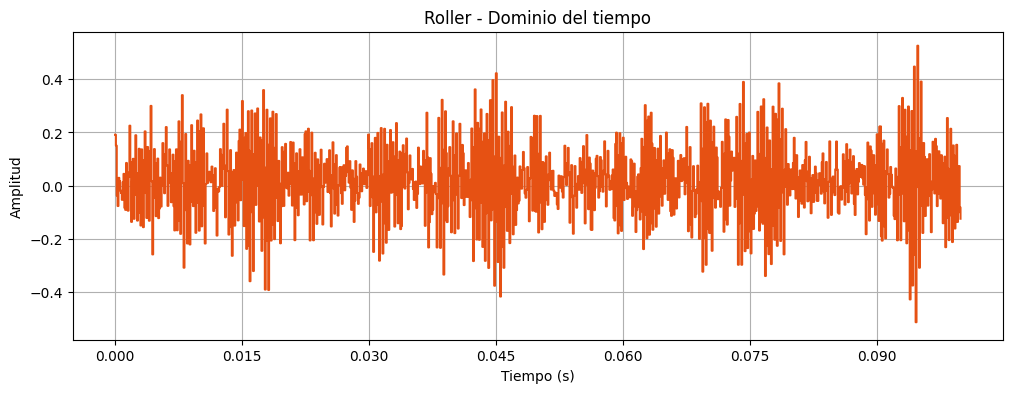

In [42]:
df_roller = Data_roller[0, 10000:11000]  # Seleccionar la primera señal si está en un array 2D

# Graficar la señal
plt.figure(figsize=(12, 4))
librosa.display.waveshow(df_roller[:1000], sr=frequence, color='#E65113')  # Cambiar color a naranja
plt.title("Roller - Dominio del tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()


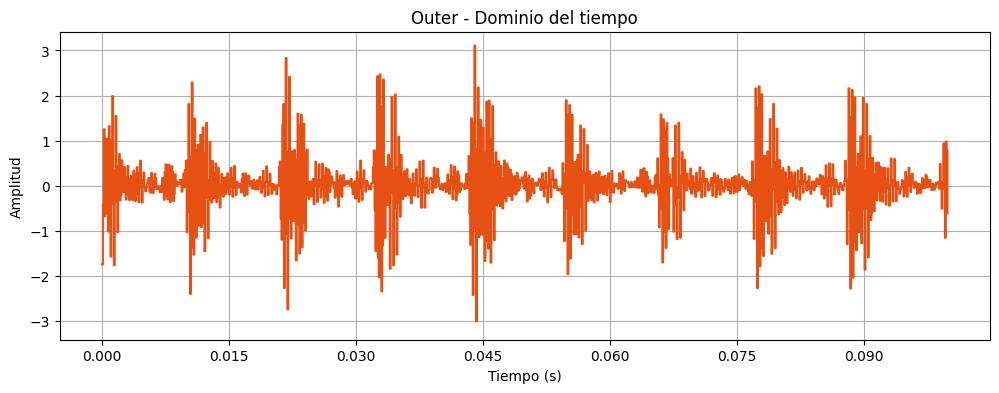

In [43]:
df_outer = Data_outer[0, 10000:11000]  # Seleccionar la primera señal si está en un array 2D

# Graficar la señal
plt.figure(figsize=(12, 4))
librosa.display.waveshow(df_outer[:1000], sr=frequence, color='#E65113')  # Cambiar color a naranja
plt.title("Outer - Dominio del tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()


### Representación acústica de las señales

In [20]:
Audio_normal = Audio(Data_normal[0], rate=frequence) 
display(Audio_normal)  

In [22]:
Audio_inner = Audio(Data_inner[0], rate=frequence) 
display(Audio_inner)  

In [24]:
Audio_roller = Audio(Data_roller[0], rate=frequence) 
display(Audio_roller)  

In [26]:
Audio_outer = Audio(Data_outer[0], rate=frequence) 
display(Audio_outer)  

### Representación gráfica de las señales acústicas en el dominio de la frecuencia

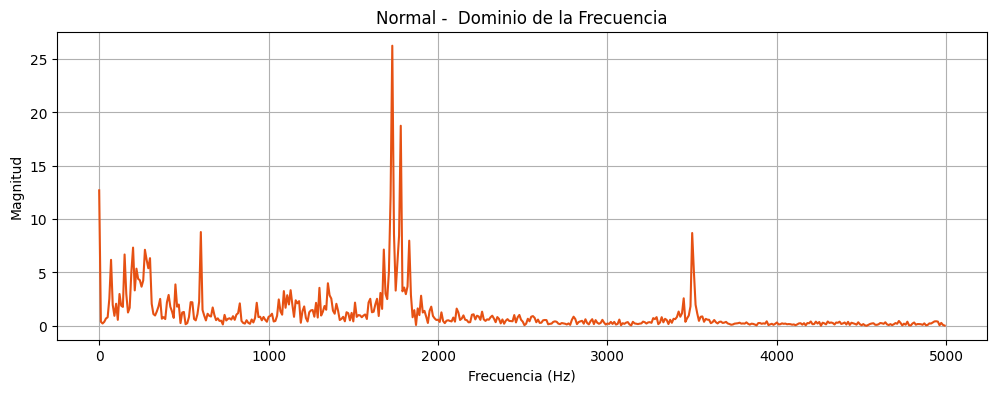

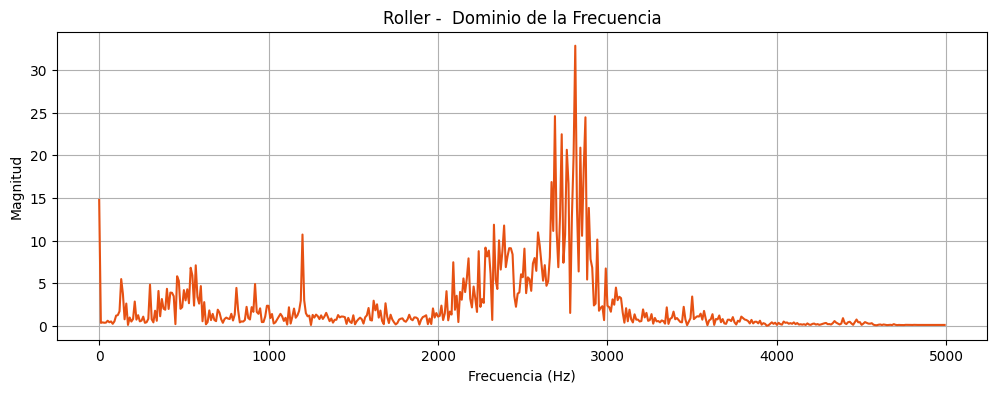

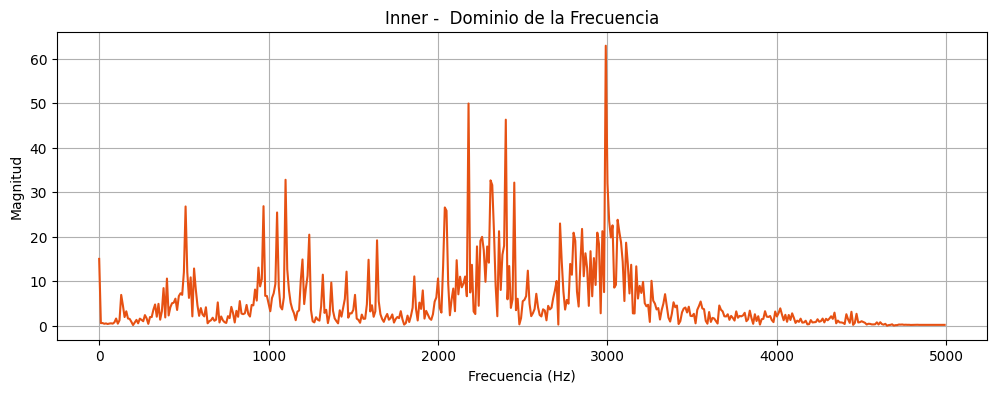

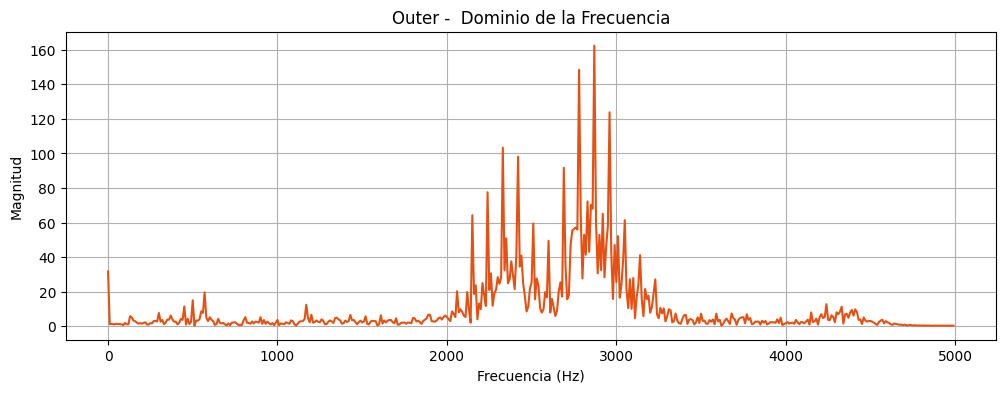

In [45]:
def plot_frequency_domain(signal, fs, title):
    """
    Grafica el dominio de la frecuencia de una señal usando FFT.
    
    Args:
        signal (numpy array): Señal de entrada en el dominio del tiempo.
        fs (int): Frecuencia de muestreo de la señal.
        title (str): Título del gráfico.
    """
    # Aplicar FFT
    N = len(signal)
    fft_signal = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_signal)[:N // 2]  # Magnitud de la FFT
    freq = np.fft.fftfreq(N, d=1/fs)[:N // 2]   # Frecuencias asociadas

    # Graficar el dominio de la frecuencia
    plt.figure(figsize=(12, 4))
    plt.plot(freq, fft_magnitude, color='#E65113')
    plt.title(f"{title} Dominio de la Frecuencia")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.grid(True)
    plt.show()

# Frecuencia de muestreo (ajustar según corresponda)
fs = 10000  # Hz



# Señales para analizar (ajustar con tus datos reales)
plot_frequency_domain(df_normal, fs, "Normal - ")
plot_frequency_domain(df_roller, fs, "Roller - ")
plot_frequency_domain(df_inner, fs, "Inner - ")
plot_frequency_domain(df_outer, fs, "Outer - ")


### Eleccción del tamaño de segmento más adecuado para el entrenamiento en los modelo CNN, LSTM y Random Forest


Evaluación de Tamaños de Segmento:

   Segmento  Varianza Media  SNR Medio  Accuracy RF
0       500        0.139130  73.348584          1.0
1      1000        0.139131  76.273273          1.0
2      2000        0.139131  79.512919          1.0
3      5000        0.139132  83.454957          1.0


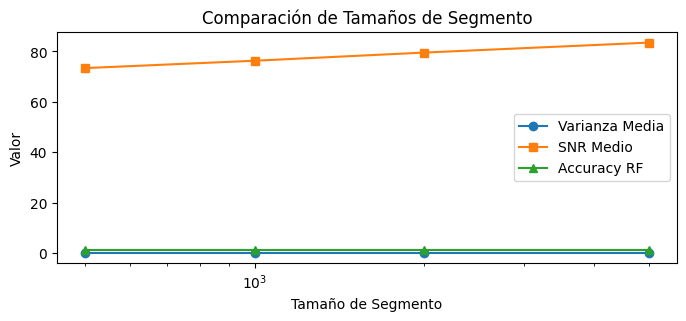

In [4]:
# Definir tamaños de segmento a evaluar
segment_sizes = [500, 1000, 2000, 5000]

# Frecuencia de muestreo
fs = 10000  

# Extraer datos de cada clase
Data_classes = {
    "Normal": dataset["normal"].flatten(),
    "Falla Pista Interna": dataset["inner"].flatten(),
    "Falla Elemento Rodante": dataset["roller"].flatten(),
    "Falla Pista Externa": dataset["outer"].flatten()
}

# Evaluación de métricas para cada tamaño de segmento
results = []

for seg_size in segment_sizes:
    varianzas = []
    snr_values = []
    class_labels = []
    features = []

    for label, (class_name, data) in enumerate(Data_classes.items()):
        num_segments = len(data) // seg_size
        
        for i in range(num_segments):
            segment = data[i * seg_size:(i + 1) * seg_size]
            
            # Cálculo de varianza
            varianzas.append(np.var(segment))
            
            # Cálculo de SNR (Señal/Ruido)
            freqs, psd = welch(segment, fs=fs, nperseg=len(segment))
            signal_power = np.sum(psd)
            noise_power = np.sum(psd[freqs > (fs / 2)])  # Ruido en altas frecuencias
            snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
            snr_values.append(snr)
            
            # Características
            features.append([np.mean(segment), np.std(segment), np.max(segment), np.min(segment), snr])
            class_labels.append(label)

    # Clasificación con Random Forest para evaluar separabilidad
    rf_model = RandomForestClassifier(random_state=42, n_estimators=50)
    accuracy = np.mean(cross_val_score(rf_model, features, class_labels, cv=5))

    # Almacenar resultados
    results.append({"Segmento": seg_size, "Varianza Media": np.mean(varianzas),
                    "SNR Medio": np.mean(snr_values), "Accuracy RF": accuracy})

# Convertir resultados en DataFrame y mostrar
df_results = pd.DataFrame(results)
print("\nEvaluación de Tamaños de Segmento:\n")
print(df_results)

# Graficar resultados
plt.figure(figsize=(8, 3))
plt.plot(df_results["Segmento"], df_results["Varianza Media"], marker='o', label="Varianza Media")
plt.plot(df_results["Segmento"], df_results["SNR Medio"], marker='s', label="SNR Medio")
plt.plot(df_results["Segmento"], df_results["Accuracy RF"], marker='^', label="Accuracy RF")
plt.xscale("log")
plt.xlabel("Tamaño de Segmento")
plt.ylabel("Valor")
plt.legend()
plt.title("Comparación de Tamaños de Segmento")
plt.grid(False)
plt.show()
